# MMSegmentation Tutorial
Welcome to MMSegmentation! 

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results. 

In [ ]:
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
# !tar xf VOCtrainval_06-Nov-2007.tar
# # Also download the test data
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar && tar xf VOCtest_06-Nov-2007.tar
# !cd VOCdevkit/VOC2007/
# !export DATA_DIR=$(pwd)

## Install MMSegmentation
This step may take several minutes. 

We use PyTorch 1.5.0 and CUDA 10.1 for this tutorial. You may install other versions by change the version number in pip install command. 

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# Install PyTorch
!pip install -U torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# Install MMCV
!pip install mmcv-full==latest+torch1.5.0+cu101 -f https://download.openmmlab.com/mmcv/dist/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already up-to-date: torch==1.5.0+cu101 in /usr/local/lib/python3.7/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6.0+cu101 in /usr/local/lib/python3.7/dist-packages (0.6.0+cu101)
Looking in links: https://download.openmmlab.com/mmcv/dist/index.html
  Using cached https://download.openmmlab.com/mmcv/dist/1.3.0/torch1.5.0/cu101/mmcv_full-latest%2Btorch1.5.0%2Bcu101-cp37-cp37m-manylinux1_x86_64.whl
  Found existing installation: mmcv-full 1.3.0
    Uninstalling mmcv-full-1.3.0:
      Successfully uninstalled mmcv-full-1.3.0


In [ ]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 2288 (delta 56), reused 118 (delta 49), pack-reused 2130
Receiving objects: 100% (2288/2288), 4.38 MiB | 9.11 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
/content/mmsegmentation
Obtaining file:///content/mmsegmentation
  Found existing installation: mmsegmentation 0.12.0
    Can't uninstall 'mmsegmentation'. No files were found to uninstall.
  Running setup.py develop for mmsegmentation


In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.5.0+cu101 True
0.12.0


## Run Inference with MMSeg trained weight

In [ ]:
!mkdir checkpoints
!wget https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmsegmentation/models/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth -P checkpoints

--2021-04-14 22:52:25--  https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmsegmentation/models/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
Resolving open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)... 52.219.58.55
Connecting to open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)|52.219.58.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196205945 (187M) [application/x-www-form-urlencoded]
Saving to: ‘checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth’

pspnet_r50-d8_512x1 100%[===================>] 187.12M  11.5MB/s    in 18s     

2021-04-14 22:52:44 (10.3 MB/s) - ‘checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth’ saved [196205945/196205945]



In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [ ]:
config_file = 'configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py'
checkpoint_file = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

In [ ]:
# build the model from a config file and a checkpoint file
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

Use load_from_local loader


In [ ]:
# test a single image
img = 'demo/demo.png'
result = inference_segmentor(model, img)

/content/mmsegmentation/mmseg/models/segmentors/base.py:271: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


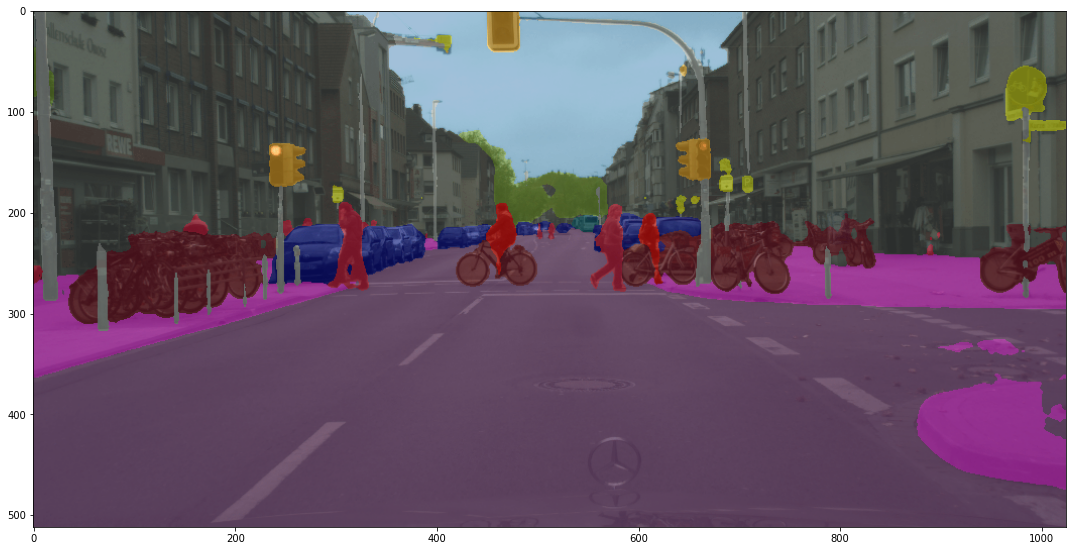

In [ ]:
# show the results
show_result_pyplot(model, img, result, get_palette('cityscapes'))

## Train a semantic segmentation model on a new dataset

To train on a customized dataset, the following steps are neccessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same perfix. To support a new dataset, we may need to modify the original file structure. 

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/docs/tutorials/new_dataset.md) for details about dataset reorganization. 

We use [Standord Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels. 
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object. 

In [ ]:
# download and unzip
!wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O standford_background.tar.gz
!tar xf standford_background.tar.gz

--2021-04-14 22:52:49--  http://dags.stanford.edu/data/iccv09Data.tar.gz
Resolving dags.stanford.edu (dags.stanford.edu)... 171.64.68.10
Connecting to dags.stanford.edu (dags.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14727974 (14M) [application/x-gzip]
Saving to: ‘standford_background.tar.gz’

standford_backgroun 100%[===================>]  14.04M  4.50MB/s    in 3.1s    

2021-04-14 22:52:52 (4.50 MB/s) - ‘standford_background.tar.gz’ saved [14727974/14727974]



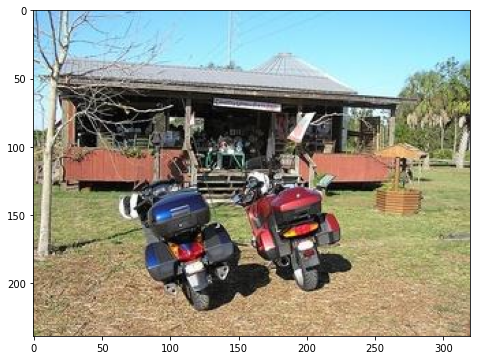

In [ ]:
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('iccv09Data/images/0100822.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

In [ ]:
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = 'iccv09Data'
img_dir = 'images'
ann_dir = 'labels'
# define class and plaette for better visualization
classes = ('sky', 'tree', 'road', 'grass', 'water', 'bldg', 'mntn', 'fg obj')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], 
           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]]
for file in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
  seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt', 
                                                         '.png')))

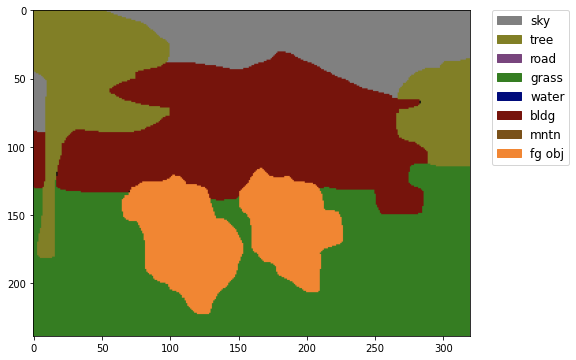

In [ ]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('iccv09Data/labels/0100822.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(8)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [ ]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StandfordBackgroundDataset`.

In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class StandfordBackgroundDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

    

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [ ]:
from mmcv import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

Since the given config is used to train PSPNet on cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [ ]:
from mmseg.apis import set_random_seed

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 8
cfg.model.auxiliary_head.num_classes = 8

# Modify dataset type and path
cfg.dataset_type = 'StandfordBackgroundDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu=8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=8,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=F

### Train and Evaluation

## Add Adversarial Training

In [ ]:
def train_step(self, data, optimizer):
    eps=0.3 
    alpha=2/255
    iters=1000
    for i in range(iters):
        imgs = data["img"]
        imgs.requires_grad = True
        all_losses = self(**data)
        losses = None
        for loss_name, loss in all_losses.items():
            if isinstance(loss, list):
                loss = sum(loss) / len(loss)
            losses = losses + loss if losses is not None else loss
        losses.backward()
        adv_data = imgs + alpha*imgs.grad.sign()
        eta = torch.clamp(adv_data - imgs, min=-eps, max=eps)
        data["img"] = torch.clamp(imgs + eta, min=0, max=1).detach_()
    losses = self(**data)
    print(all_losses, losses)
    loss, log_vars = self._parse_losses(losses)
    outputs = dict(
            loss=loss, log_vars=log_vars, num_samples=len(data['img_metas']))
    return outputs

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
import types

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES
model.train_step = types.MethodType(train_step, model)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

/usr/local/lib/python3.7/dist-packages/mmcv/utils/misc.py:304: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  f'"{src_arg_name}" is deprecated in '
2021-04-14 22:53:17,874 - mmseg - INFO - Loaded 572 images
2021-04-14 22:53:18,482 - mmseg - INFO - Use load_from_openmmlab loader
2021-04-14 22:53:18,567 - mmseg - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2021-04-14 22:53:18,645 - mmseg - INFO - Loaded 143 images
2021-04-14 22:53:18,646 - mmseg - INFO - load checkpoint from checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
2021-04-14 22:53:18,647 - mmseg - INFO - Use load_from_local loader
2021-04-14 22:53:18,817 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torc

{'decode.loss_seg': tensor(1.7423, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([18.1082], device='cuda:0'), 'aux.loss_seg': tensor(0.6960, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([7.7431], device='cuda:0')} {'decode.loss_seg': tensor(1.7566, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([12.3135], device='cuda:0'), 'aux.loss_seg': tensor(0.7023, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([7.6292], device='cuda:0')}
{'decode.loss_seg': tensor(1.7972, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([15.8243], device='cuda:0'), 'aux.loss_seg': tensor(0.7068, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([22.6322], device='cuda:0')} {'decode.loss_seg': tensor(1.8033, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([8.7574], device='cuda:0'), 'aux.loss_seg': tensor(0.7085, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([18.9217], d

2021-04-14 22:53:23,595 - mmseg - INFO - Iter [10/200]	lr: 9.598e-03, eta: 0:01:23, time: 0.440, data_time: 0.048, memory: 3525, decode.loss_seg: 1.6431, decode.acc_seg: 35.6174, aux.loss_seg: 0.7130, aux.acc_seg: 33.5387, loss: 2.3561


{'decode.loss_seg': tensor(1.2827, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([68.2299], device='cuda:0'), 'aux.loss_seg': tensor(0.6830, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([71.8815], device='cuda:0')} {'decode.loss_seg': tensor(1.3654, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([60.6998], device='cuda:0'), 'aux.loss_seg': tensor(0.7017, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([62.0670], device='cuda:0')}
{'decode.loss_seg': tensor(1.2005, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([52.8650], device='cuda:0'), 'aux.loss_seg': tensor(0.6299, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([55.0354], device='cuda:0')} {'decode.loss_seg': tensor(1.2675, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([49.7528], device='cuda:0'), 'aux.loss_seg': tensor(0.6444, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([51.8400]

2021-04-14 22:53:27,367 - mmseg - INFO - Iter [20/200]	lr: 9.149e-03, eta: 0:01:13, time: 0.377, data_time: 0.004, memory: 3525, decode.loss_seg: 1.1888, decode.acc_seg: 51.8540, aux.loss_seg: 0.6116, aux.acc_seg: 46.5520, loss: 1.8004


{'decode.loss_seg': tensor(1.5756, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([47.9734], device='cuda:0'), 'aux.loss_seg': tensor(0.7168, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([40.1907], device='cuda:0')} {'decode.loss_seg': tensor(1.8132, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([39.3072], device='cuda:0'), 'aux.loss_seg': tensor(0.7516, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([26.8475], device='cuda:0')}
{'decode.loss_seg': tensor(0.9919, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([54.1971], device='cuda:0'), 'aux.loss_seg': tensor(0.5495, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([42.4982], device='cuda:0')} {'decode.loss_seg': tensor(1.1274, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([45.9839], device='cuda:0'), 'aux.loss_seg': tensor(0.5660, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([41.7099]

2021-04-14 22:53:31,131 - mmseg - INFO - Iter [30/200]	lr: 8.698e-03, eta: 0:01:07, time: 0.376, data_time: 0.004, memory: 3525, decode.loss_seg: 0.9321, decode.acc_seg: 53.1420, aux.loss_seg: 0.4754, aux.acc_seg: 50.3564, loss: 1.4075


{'decode.loss_seg': tensor(0.9886, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([65.9470], device='cuda:0'), 'aux.loss_seg': tensor(0.5255, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([56.0461], device='cuda:0')} {'decode.loss_seg': tensor(1.1683, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([58.5350], device='cuda:0'), 'aux.loss_seg': tensor(0.5482, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([53.9661], device='cuda:0')}
{'decode.loss_seg': tensor(0.7354, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([61.9287], device='cuda:0'), 'aux.loss_seg': tensor(0.4411, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([50.5461], device='cuda:0')} {'decode.loss_seg': tensor(0.8705, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([58.3603], device='cuda:0'), 'aux.loss_seg': tensor(0.4577, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([50.9151]

2021-04-14 22:53:34,897 - mmseg - INFO - Iter [40/200]	lr: 8.244e-03, eta: 0:01:02, time: 0.377, data_time: 0.004, memory: 3525, decode.loss_seg: 0.7993, decode.acc_seg: 58.8447, aux.loss_seg: 0.3995, aux.acc_seg: 55.5841, loss: 1.1988


{'decode.loss_seg': tensor(0.7392, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([71.6413], device='cuda:0'), 'aux.loss_seg': tensor(0.3503, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([77.4893], device='cuda:0')} {'decode.loss_seg': tensor(0.8559, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([67.2485], device='cuda:0'), 'aux.loss_seg': tensor(0.3908, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([69.5471], device='cuda:0')}
{'decode.loss_seg': tensor(0.4198, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([82.2344], device='cuda:0'), 'aux.loss_seg': tensor(0.3123, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([72.7428], device='cuda:0')} {'decode.loss_seg': tensor(0.5178, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([76.5375], device='cuda:0'), 'aux.loss_seg': tensor(0.3370, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([72.5264]

2021-04-14 22:53:38,664 - mmseg - INFO - Iter [50/200]	lr: 7.788e-03, eta: 0:00:58, time: 0.377, data_time: 0.004, memory: 3525, decode.loss_seg: 0.9392, decode.acc_seg: 56.7457, aux.loss_seg: 0.4355, aux.acc_seg: 54.1258, loss: 1.3747


{'decode.loss_seg': tensor(0.6702, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([71.5797], device='cuda:0'), 'aux.loss_seg': tensor(0.3332, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([69.5488], device='cuda:0')} {'decode.loss_seg': tensor(0.9441, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([59.0017], device='cuda:0'), 'aux.loss_seg': tensor(0.3996, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([60.6424], device='cuda:0')}
{'decode.loss_seg': tensor(0.6953, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([72.6583], device='cuda:0'), 'aux.loss_seg': tensor(0.3188, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([72.3513], device='cuda:0')} {'decode.loss_seg': tensor(0.8004, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([65.2542], device='cuda:0'), 'aux.loss_seg': tensor(0.3627, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([66.0280]

2021-04-14 22:53:42,437 - mmseg - INFO - Iter [60/200]	lr: 7.328e-03, eta: 0:00:54, time: 0.377, data_time: 0.004, memory: 3525, decode.loss_seg: 0.9776, decode.acc_seg: 59.2293, aux.loss_seg: 0.4273, aux.acc_seg: 57.4424, loss: 1.4049


{'decode.loss_seg': tensor(1.0632, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([59.0805], device='cuda:0'), 'aux.loss_seg': tensor(0.4259, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([62.2772], device='cuda:0')} {'decode.loss_seg': tensor(1.2054, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([53.0382], device='cuda:0'), 'aux.loss_seg': tensor(0.4712, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([55.4052], device='cuda:0')}
{'decode.loss_seg': tensor(0.9610, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([54.5517], device='cuda:0'), 'aux.loss_seg': tensor(0.3877, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([52.0676], device='cuda:0')} {'decode.loss_seg': tensor(1.1817, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([45.0510], device='cuda:0'), 'aux.loss_seg': tensor(0.4336, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([46.6612]

2021-04-14 22:53:46,211 - mmseg - INFO - Iter [70/200]	lr: 6.865e-03, eta: 0:00:50, time: 0.377, data_time: 0.004, memory: 3525, decode.loss_seg: 0.9139, decode.acc_seg: 54.0616, aux.loss_seg: 0.3789, aux.acc_seg: 53.4753, loss: 1.2928


{'decode.loss_seg': tensor(0.5494, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([72.1573], device='cuda:0'), 'aux.loss_seg': tensor(0.2938, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([60.3224], device='cuda:0')} {'decode.loss_seg': tensor(0.6269, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([63.5929], device='cuda:0'), 'aux.loss_seg': tensor(0.3317, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([56.2672], device='cuda:0')}
{'decode.loss_seg': tensor(0.7765, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([67.1597], device='cuda:0'), 'aux.loss_seg': tensor(0.3598, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([62.1992], device='cuda:0')} {'decode.loss_seg': tensor(0.9513, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([58.5728], device='cuda:0'), 'aux.loss_seg': tensor(0.4315, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([51.6481]

2021-04-14 22:53:51,033 - mmseg - INFO - Iter [80/200]	lr: 6.398e-03, eta: 0:00:47, time: 0.482, data_time: 0.100, memory: 3525, decode.loss_seg: 0.8440, decode.acc_seg: 59.5508, aux.loss_seg: 0.3889, aux.acc_seg: 56.1523, loss: 1.2329


{'decode.loss_seg': tensor(0.6836, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([68.4078], device='cuda:0'), 'aux.loss_seg': tensor(0.3083, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([66.8669], device='cuda:0')} {'decode.loss_seg': tensor(0.9097, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([59.0973], device='cuda:0'), 'aux.loss_seg': tensor(0.3630, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([57.7271], device='cuda:0')}
{'decode.loss_seg': tensor(0.7809, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([72.4936], device='cuda:0'), 'aux.loss_seg': tensor(0.3700, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([63.4035], device='cuda:0')} {'decode.loss_seg': tensor(0.8640, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([70.3770], device='cuda:0'), 'aux.loss_seg': tensor(0.3977, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([60.5892]

2021-04-14 22:53:54,803 - mmseg - INFO - Iter [90/200]	lr: 5.928e-03, eta: 0:00:43, time: 0.377, data_time: 0.004, memory: 3525, decode.loss_seg: 0.8670, decode.acc_seg: 59.5609, aux.loss_seg: 0.3918, aux.acc_seg: 55.7534, loss: 1.2587


{'decode.loss_seg': tensor(0.6949, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([65.6494], device='cuda:0'), 'aux.loss_seg': tensor(0.3562, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([61.9404], device='cuda:0')} {'decode.loss_seg': tensor(0.9317, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([55.0283], device='cuda:0'), 'aux.loss_seg': tensor(0.4246, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([52.3918], device='cuda:0')}
{'decode.loss_seg': tensor(0.7582, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([60.6022], device='cuda:0'), 'aux.loss_seg': tensor(0.3640, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([54.0312], device='cuda:0')} {'decode.loss_seg': tensor(0.7510, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([61.6436], device='cuda:0'), 'aux.loss_seg': tensor(0.3615, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([58.8991]

2021-04-14 22:53:58,565 - mmseg - INFO - Iter [100/200]	lr: 5.453e-03, eta: 0:00:39, time: 0.376, data_time: 0.004, memory: 3525, decode.loss_seg: 0.7637, decode.acc_seg: 60.9227, aux.loss_seg: 0.3450, aux.acc_seg: 58.4287, loss: 1.1088


{'decode.loss_seg': tensor(0.7432, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([58.3284], device='cuda:0'), 'aux.loss_seg': tensor(0.3464, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([57.9924], device='cuda:0')} {'decode.loss_seg': tensor(0.9156, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([51.1765], device='cuda:0'), 'aux.loss_seg': tensor(0.4104, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([49.7221], device='cuda:0')}
{'decode.loss_seg': tensor(0.9874, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([60.2655], device='cuda:0'), 'aux.loss_seg': tensor(0.3771, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([60.8042], device='cuda:0')} {'decode.loss_seg': tensor(1.1456, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([56.7572], device='cuda:0'), 'aux.loss_seg': tensor(0.4585, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([56.1649]

2021-04-14 22:54:02,341 - mmseg - INFO - Iter [110/200]	lr: 4.974e-03, eta: 0:00:35, time: 0.378, data_time: 0.004, memory: 3525, decode.loss_seg: 0.8437, decode.acc_seg: 58.4807, aux.loss_seg: 0.3562, aux.acc_seg: 57.0842, loss: 1.1999


{'decode.loss_seg': tensor(0.5934, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([69.0002], device='cuda:0'), 'aux.loss_seg': tensor(0.2650, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([73.1562], device='cuda:0')} {'decode.loss_seg': tensor(0.8638, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([59.1000], device='cuda:0'), 'aux.loss_seg': tensor(0.3776, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([58.0158], device='cuda:0')}
{'decode.loss_seg': tensor(1.0191, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([63.7554], device='cuda:0'), 'aux.loss_seg': tensor(0.4228, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([63.4741], device='cuda:0')} {'decode.loss_seg': tensor(1.0443, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([60.2003], device='cuda:0'), 'aux.loss_seg': tensor(0.4485, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([55.9677]

2021-04-14 22:54:06,116 - mmseg - INFO - Iter [120/200]	lr: 4.489e-03, eta: 0:00:31, time: 0.378, data_time: 0.004, memory: 3525, decode.loss_seg: 0.7257, decode.acc_seg: 61.1287, aux.loss_seg: 0.3242, aux.acc_seg: 59.0547, loss: 1.0499


{'decode.loss_seg': tensor(0.6808, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([55.8317], device='cuda:0'), 'aux.loss_seg': tensor(0.3083, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([54.6354], device='cuda:0')} {'decode.loss_seg': tensor(0.7571, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([54.0079], device='cuda:0'), 'aux.loss_seg': tensor(0.3384, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([52.5995], device='cuda:0')}
{'decode.loss_seg': tensor(0.4090, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([69.4447], device='cuda:0'), 'aux.loss_seg': tensor(0.2024, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([66.7606], device='cuda:0')} {'decode.loss_seg': tensor(0.5149, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([65.4858], device='cuda:0'), 'aux.loss_seg': tensor(0.2408, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([63.4808]

2021-04-14 22:54:09,888 - mmseg - INFO - Iter [130/200]	lr: 3.998e-03, eta: 0:00:27, time: 0.377, data_time: 0.004, memory: 3525, decode.loss_seg: 0.8076, decode.acc_seg: 60.3982, aux.loss_seg: 0.3525, aux.acc_seg: 60.4295, loss: 1.1601


{'decode.loss_seg': tensor(0.5995, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([68.4114], device='cuda:0'), 'aux.loss_seg': tensor(0.3054, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([68.7332], device='cuda:0')} {'decode.loss_seg': tensor(0.7001, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([67.3552], device='cuda:0'), 'aux.loss_seg': tensor(0.3443, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([65.9063], device='cuda:0')}
{'decode.loss_seg': tensor(0.4593, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([58.0524], device='cuda:0'), 'aux.loss_seg': tensor(0.1826, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([59.2106], device='cuda:0')} {'decode.loss_seg': tensor(0.5181, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([53.1153], device='cuda:0'), 'aux.loss_seg': tensor(0.2042, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([55.7434]

2021-04-14 22:54:13,675 - mmseg - INFO - Iter [140/200]	lr: 3.500e-03, eta: 0:00:23, time: 0.379, data_time: 0.004, memory: 3525, decode.loss_seg: 0.7204, decode.acc_seg: 60.4828, aux.loss_seg: 0.3166, aux.acc_seg: 59.0158, loss: 1.0370


{'decode.loss_seg': tensor(0.4384, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([53.6459], device='cuda:0'), 'aux.loss_seg': tensor(0.1908, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([53.9083], device='cuda:0')} {'decode.loss_seg': tensor(0.4803, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([53.1279], device='cuda:0'), 'aux.loss_seg': tensor(0.2213, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([52.2516], device='cuda:0')}
{'decode.loss_seg': tensor(0.5275, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([69.2005], device='cuda:0'), 'aux.loss_seg': tensor(0.2499, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([68.5064], device='cuda:0')} {'decode.loss_seg': tensor(0.6568, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([66.1945], device='cuda:0'), 'aux.loss_seg': tensor(0.3035, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([64.0251]

2021-04-14 22:54:18,580 - mmseg - INFO - Iter [150/200]	lr: 2.994e-03, eta: 0:00:19, time: 0.490, data_time: 0.104, memory: 3525, decode.loss_seg: 0.6319, decode.acc_seg: 66.9018, aux.loss_seg: 0.2970, aux.acc_seg: 64.9278, loss: 0.9289


{'decode.loss_seg': tensor(0.4392, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([73.0007], device='cuda:0'), 'aux.loss_seg': tensor(0.2019, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([73.3221], device='cuda:0')} {'decode.loss_seg': tensor(0.5225, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([68.9743], device='cuda:0'), 'aux.loss_seg': tensor(0.2343, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([69.4532], device='cuda:0')}
{'decode.loss_seg': tensor(0.4508, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([81.8956], device='cuda:0'), 'aux.loss_seg': tensor(0.2268, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([81.6694], device='cuda:0')} {'decode.loss_seg': tensor(0.7245, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([70.3857], device='cuda:0'), 'aux.loss_seg': tensor(0.3337, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([68.7071]

2021-04-14 22:54:22,361 - mmseg - INFO - Iter [160/200]	lr: 2.478e-03, eta: 0:00:15, time: 0.378, data_time: 0.004, memory: 3525, decode.loss_seg: 0.7242, decode.acc_seg: 66.3293, aux.loss_seg: 0.3297, aux.acc_seg: 64.6741, loss: 1.0539


{'decode.loss_seg': tensor(0.4720, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([72.4823], device='cuda:0'), 'aux.loss_seg': tensor(0.2363, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([69.8679], device='cuda:0')} {'decode.loss_seg': tensor(0.6055, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([64.3297], device='cuda:0'), 'aux.loss_seg': tensor(0.2902, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([62.2959], device='cuda:0')}
{'decode.loss_seg': tensor(0.7004, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([67.4351], device='cuda:0'), 'aux.loss_seg': tensor(0.3132, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([67.5867], device='cuda:0')} {'decode.loss_seg': tensor(0.8157, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([64.0242], device='cuda:0'), 'aux.loss_seg': tensor(0.3540, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([63.0758]

2021-04-14 22:54:26,133 - mmseg - INFO - Iter [170/200]	lr: 1.949e-03, eta: 0:00:11, time: 0.377, data_time: 0.004, memory: 3525, decode.loss_seg: 0.7105, decode.acc_seg: 62.2753, aux.loss_seg: 0.3209, aux.acc_seg: 60.7569, loss: 1.0313


{'decode.loss_seg': tensor(0.5920, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([71.5582], device='cuda:0'), 'aux.loss_seg': tensor(0.2892, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([71.3787], device='cuda:0')} {'decode.loss_seg': tensor(0.7050, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([69.9440], device='cuda:0'), 'aux.loss_seg': tensor(0.3181, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([68.9371], device='cuda:0')}
{'decode.loss_seg': tensor(0.7087, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([63.8483], device='cuda:0'), 'aux.loss_seg': tensor(0.3351, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([61.4124], device='cuda:0')} {'decode.loss_seg': tensor(0.7884, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([60.4168], device='cuda:0'), 'aux.loss_seg': tensor(0.3738, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([57.1939]

2021-04-14 22:54:29,908 - mmseg - INFO - Iter [180/200]	lr: 1.402e-03, eta: 0:00:07, time: 0.377, data_time: 0.004, memory: 3525, decode.loss_seg: 0.7245, decode.acc_seg: 59.3215, aux.loss_seg: 0.3234, aux.acc_seg: 57.7707, loss: 1.0480


{'decode.loss_seg': tensor(0.8615, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([54.0148], device='cuda:0'), 'aux.loss_seg': tensor(0.4144, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([53.2679], device='cuda:0')} {'decode.loss_seg': tensor(1.1007, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([49.4352], device='cuda:0'), 'aux.loss_seg': tensor(0.5013, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([46.6362], device='cuda:0')}
{'decode.loss_seg': tensor(0.4999, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([73.8272], device='cuda:0'), 'aux.loss_seg': tensor(0.2422, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([73.9933], device='cuda:0')} {'decode.loss_seg': tensor(0.5514, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([73.0631], device='cuda:0'), 'aux.loss_seg': tensor(0.2610, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([71.5395]

2021-04-14 22:54:33,671 - mmseg - INFO - Iter [190/200]	lr: 8.277e-04, eta: 0:00:03, time: 0.376, data_time: 0.004, memory: 3525, decode.loss_seg: 0.6805, decode.acc_seg: 64.9457, aux.loss_seg: 0.3127, aux.acc_seg: 63.5525, loss: 0.9931


{'decode.loss_seg': tensor(0.2962, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([65.6862], device='cuda:0'), 'aux.loss_seg': tensor(0.1621, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([61.4340], device='cuda:0')} {'decode.loss_seg': tensor(0.4413, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([56.5851], device='cuda:0'), 'aux.loss_seg': tensor(0.2196, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([55.0274], device='cuda:0')}
{'decode.loss_seg': tensor(0.5500, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([58.5043], device='cuda:0'), 'aux.loss_seg': tensor(0.2400, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([57.3244], device='cuda:0')} {'decode.loss_seg': tensor(0.5966, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([56.4583], device='cuda:0'), 'aux.loss_seg': tensor(0.2626, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([54.7333]

2021-04-14 22:54:37,431 - mmseg - INFO - Saving checkpoint at 200 iterations


{'decode.loss_seg': tensor(0.4914, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([72.8788], device='cuda:0'), 'aux.loss_seg': tensor(0.2278, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([73.5388], device='cuda:0')} {'decode.loss_seg': tensor(0.5806, device='cuda:0', grad_fn=<MulBackward0>), 'decode.acc_seg': tensor([69.8179], device='cuda:0'), 'aux.loss_seg': tensor(0.2692, device='cuda:0', grad_fn=<MulBackward0>), 'aux.acc_seg': tensor([70.1454], device='cuda:0')}
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 39.2 task/s, elapsed: 4s, ETA:     0s

2021-04-14 22:54:42,749 - mmseg - INFO - per class results:
2021-04-14 22:54:42,751 - mmseg - INFO - 
+--------+-------+-------+
| Class  | IoU   | Acc   |
+--------+-------+-------+
| sky    | 86.21 | 91.49 |
| tree   | 67.46 | 80.06 |
| road   | 77.76 | 96.02 |
| grass  | 73.88 | 92.48 |
| water  | 1.35  | 1.37  |
| bldg   | 75.15 | 88.21 |
| mntn   | 0.0   | 0.0   |
| fg obj | 63.85 | 74.3  |
+--------+-------+-------+
2021-04-14 22:54:42,752 - mmseg - INFO - Summary:
2021-04-14 22:54:42,761 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 55.71 | 65.49 | 83.33 |
+--------+-------+-------+-------+
2021-04-14 22:54:42,772 - mmseg - INFO - Iter(val) [200]	mIoU: 0.5571, mAcc: 0.6549, aAcc: 0.8333, IoU.sky: 0.8621, IoU.tree: 0.6746, IoU.road: 0.7776, IoU.grass: 0.7388, IoU.water: 0.0135, IoU.bldg: 0.7515, IoU.mntn: 0.0000, IoU.fg obj: 0.6385, Acc.sky: 0.9149, Acc.tree: 0.8006, Acc.road: 0.9602, Acc.gras

Inference with trained model

/content/mmsegmentation/mmseg/models/segmentors/base.py:271: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

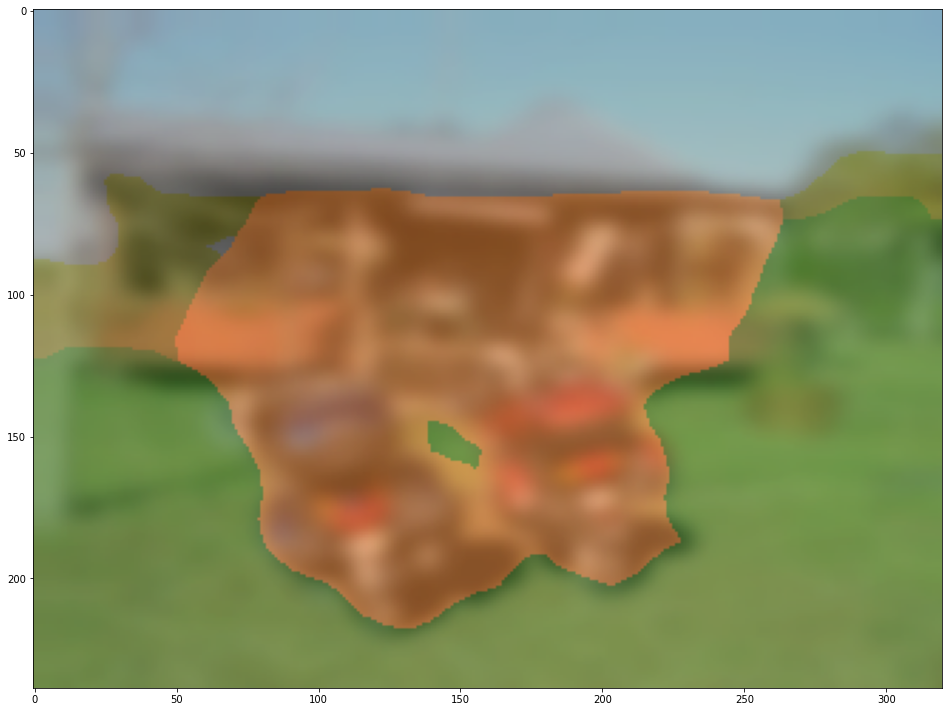

In [ ]:
img = mmcv.imread('iccv09Data/images/0100822.jpg')
# img = mmcv.imread('/content/mmsegmentation/VOCdevkit/VOC2007/JPEGImages/000001.jpg')
img = mmcv.imread('iccv09Data/images/test.jpg')
model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)